In [20]:
#%%
import shutil, json, sys, os, pickle, h5py, scipy
from os import path, chmod
import numpy as np
import pandas as pd 
from yacs.config import CfgNode as CN

import matplotlib.pyplot as plt
%matplotlib inline

from lfads_tf2.subclasses.behavior.models import BehaviorLFADS
from lfads_tf2.tuples import LoadableData, LFADSInput
from lfads_tf2.utils import load_posterior_averages, restrict_gpu_usage, unflatten
restrict_gpu_usage(0)

from nomad.models import AlignLFADS
from nomad.tuples import AlignInput, SingleModelOutput, AlignmentOutput
from nomad.defaults import get_cfg_defaults

import tensorflow as tf
tf.config.experimental_run_functions_eagerly(
    True
)

from utils import get_causal_model_output, generate_lagged_matrix, fit_and_eval_decoder

In [3]:
# train the LFADS Day 0 model
if os.path.exists('day0_model/lfads_ckpts/'):
    model = BehaviorLFADS(model_dir='day0_model')
else:
    model = BehaviorLFADS(cfg_path='configs/lfads.yaml')
    model.train()

Loading model from day0_model.
Loading datasets with prefix lfads from chopped_data/day0/
Restoring the most recent model.


In [4]:
# load trialized data 
with open('trialized_data/day0_trials.pkl', 'rb') as f:
    day0_trials= pickle.load(f)
spikes = day0_trials['spikes']
stack_spikes = np.dstack(spikes)

# get causal LFADS Day 0 outputs (trialized)
day0_gen_states = np.dstack([get_causal_model_output(model, 
                            0.02, 
                            stack_spikes[:,:,tr], 
                            ['gen_states'], 
                            {
                                'gen_states': model.cfg.MODEL.GEN_DIM
                            })['gen_states'] for tr in range(stack_spikes.shape[2])])

In [5]:
# train decoder 
behavior = np.concatenate(day0_trials['force'], axis=-1).T
keep_trials = np.isnan(behavior).sum(axis=(1,2)) == 0
behavior = behavior[keep_trials, :, :]
day0_gen_states = day0_gen_states.T[keep_trials, :, :]
ntrials, ndim, ntime = behavior.shape

n_train_trials = int(0.8 * ntrials)
n_test_trials = ntrials - n_train_trials
train_trials = np.random.choice(ntrials, n_train_trials, replace=False)
test_trials = np.setdiff1d(np.arange(ntrials), train_trials)

train_behavior = behavior[train_trials, :, :]
test_behavior = behavior[test_trials, :, :]
train_gen_states = day0_gen_states[train_trials, :, :]
test_gen_states = day0_gen_states[test_trials, :, :]

decode_train_behavior = np.reshape(np.swapaxes(train_behavior, 0, 1), (ndim, n_train_trials * ntime)).T
decode_test_behavior = np.reshape(np.swapaxes(test_behavior, 0, 1), (ndim, n_test_trials * ntime)).T
decode_train_neural = np.reshape(np.swapaxes(train_gen_states, 0, 1), (model.cfg.MODEL.GEN_DIM, n_train_trials * ntime)).T
decode_test_neural = np.reshape(np.swapaxes(test_gen_states, 0, 1), (model.cfg.MODEL.GEN_DIM, n_test_trials * ntime)).T

lagged_train_gen_states = generate_lagged_matrix(decode_train_neural, 3)
lagged_test_gen_states = generate_lagged_matrix(decode_test_neural, 3)
score, decoder, pred_force = fit_and_eval_decoder(
    lagged_train_gen_states,
    decode_train_behavior[3:, :],
    lagged_test_gen_states,
    decode_test_behavior[3:, :],
    return_preds=True
    )
print(score)

/home/bkarpo2/miniconda3/envs/natcomms/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/bkarpo2/miniconda3/envs/natcomms/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in s

0.942693804240786


/home/bkarpo2/miniconda3/envs/natcomms/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [6]:
# plot decoder outputs 
plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_aspect('equal')
true_behavior = np.split(decode_test_behavior, n_test_trials, axis=0)
true_plots = [plt.plot(tr[:, 0], tr[:, 1], label='True', color='k') for tr in true_behavior]
predicted_behavior = np.split(np.pad(pred_force, ((3,0), (0,0)), constant_values=np.nan), n_test_trials, axis=0)
pred_plots = [plt.plot(tr[:, 0], tr[:, 1], label='Pred', color='r', alpha=0.7) for tr in predicted_behavior]
# make axes invisible
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.legend([true_plots[0][0], pred_plots[0][0]], ['True', 'Pred'])
plt.text(-700, 550, 'Force $R^2$ = {:.2f}'.format(score))

Text(-700, 550, 'Force $R^2$ = 0.94')

In [7]:
# if we pass Day K data through the model 
with open('trialized_data/dayk_trials.pkl', 'rb') as f:
    dayk_trials= pickle.load(f)
spikes = dayk_trials['spikes']
stack_spikes = np.dstack(spikes)

# get causal LFADS Day K outputs (trialized)
dayk_gen_states = np.dstack([get_causal_model_output(model, 
                            0.02, 
                            stack_spikes[:,:,tr], 
                            ['gen_states'], 
                            {
                                'gen_states': model.cfg.MODEL.GEN_DIM
                            })['gen_states'] for tr in range(stack_spikes.shape[2])])

In [8]:
# the decoder does not generalize well to Day K data
dayk_behavior = np.concatenate(dayk_trials['force'], axis=-1).T
keep_trials = np.isnan(dayk_behavior).sum(axis=(1,2)) == 0
valid_dayk_behavior = dayk_behavior[keep_trials, :, :]
valid_dayk_gen_states = dayk_gen_states.T[keep_trials, :, :]
ntime, ndims, ntrials = valid_dayk_gen_states.shape

decode_gen_states = np.reshape(np.swapaxes(valid_dayk_gen_states, 0, 1), (model.cfg.MODEL.GEN_DIM, ntrials * ntime)).T
lagged_decode_gen_states = generate_lagged_matrix(decode_gen_states, 3)
decode_behavior = np.reshape(np.swapaxes(valid_dayk_behavior, 0, 1), (2, ntrials * ntime)).T

score = decoder.score(lagged_decode_gen_states, decode_behavior[3:, :])
dayk_pred_force = decoder.predict(lagged_decode_gen_states)
print(score)

0.42188596278298646


/home/bkarpo2/miniconda3/envs/natcomms/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [9]:
# plot decoder outputs 
plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_aspect('equal')
true_behavior = np.split(decode_behavior, ntrials, axis=0)
true_plots = [plt.plot(tr[:, 0], tr[:, 1], label='True', color='k', alpha=0.7) for tr in true_behavior]
predicted_behavior = np.split(np.pad(dayk_pred_force, ((3,0), (0,0)), constant_values=np.nan), ntrials, axis=0)
pred_plots = [plt.plot(tr[:, 0], tr[:, 1], label='Pred', color='r', alpha=0.7) for tr in predicted_behavior]
# make axes invisible
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.legend([true_plots[0][0], pred_plots[0][0]], ['True', 'Pred'])
plt.text(-950, 550, 'Force $R^2$ = {:.2f}'.format(score))

Text(-950, 550, 'Force $R^2$ = 0.42')

In [10]:
# this is a job for nomad 
align_cfg = get_cfg_defaults()
cfg_update_path = 'configs/nomad.yaml'
align_cfg.merge_from_file(cfg_update_path)
align_model = AlignLFADS(cfg_node=align_cfg)

# load the h5 files into the model
day0_datadict = h5py.File('chopped_data/day0/lfads_Jango_20150730_001.h5', 'r')
dayk_datadict = h5py.File('chopped_data/day95/lfads_Jango_20151102_001.h5', 'r')

Initializing new aligner
Loading model from align_model/pbt_model.
Loading datasets with prefix lfads from chopped_data/day0/
Restoring the most recent model.
Loading model from align_model/pbt_model.
Loading datasets with prefix lfads from chopped_data/day0/
Restoring the most recent model.


In [11]:
align_input = AlignInput(
    day0_train_data=day0_datadict['train_data'],
    day0_valid_data=day0_datadict['valid_data'],
    dayk_train_data=dayk_datadict['train_data'],
    dayk_valid_data=dayk_datadict['valid_data'],
    day0_train_inds=day0_datadict['train_inds'],
    day0_valid_inds=day0_datadict['valid_inds'],
    dayk_train_inds=dayk_datadict['train_inds'],
    dayk_valid_inds=dayk_datadict['valid_inds'])
align_model.load_datasets(align_input)
# move the day 95 norm parameters to appropriate location
shutil.copy('chopped_data/day95/normalization.h5', 'align_model/normalization_dayk.h5')
align_model.smart_init() # loads the normalization matrix in

Using datasets passed as arguments to `load_datasets`.
Setting Day K normalization parameters...


In [14]:
if not os.path.exists('align_model/align_ckpts/'):
    done = False
    while not done:
        results = align_model.train_epoch()
        done = results.get('done', False)

Epoch 1/9999, Patience: 0, LR: 4.00E-04
4/4 [==============================] - 12s 3s/step
    loss: 16.538 -     kl: 16.394 -     nll: 0.366 - gnorm: 1200005.750 - kl_gnorm: 120.001 - nll_gnorm: 0.033
val_loss: 12.615 - val_kl: 12.580 - val_nll: 0.359
Epoch 2/9999, Patience: 0, LR: 4.00E-04
4/4 [==============================] - 10s 3s/step
    loss: 9.650 -     kl: 9.473 -     nll: 0.355 - gnorm: 576096.688 - kl_gnorm: 57.611 - nll_gnorm: 0.058
val_loss: 9.154 - val_kl: 9.084 - val_nll: 0.350
Epoch 3/9999, Patience: 0, LR: 4.00E-04
4/4 [==============================] - 10s 3s/step
    loss: 8.287 -     kl: 8.078 -     nll: 0.345 - gnorm: 374722.875 - kl_gnorm: 37.472 - nll_gnorm: 0.078
val_loss: 8.154 - val_kl: 8.053 - val_nll: 0.341
Epoch 4/9999, Patience: 0, LR: 4.00E-04
4/4 [==============================] - 10s 3s/step
    loss: 8.208 -     kl: 7.968 -     nll: 0.337 - gnorm: 360085.312 - kl_gnorm: 36.004 - nll_gnorm: 0.095
val_loss: 8.135 - val_kl: 8.004 - val_nll: 0.333
Epoch 

In [16]:
# get NoMAD outputs 
with open('trialized_data/dayk_trials.pkl', 'rb') as f:
    dayk_trials= pickle.load(f)
spikes = dayk_trials['spikes']
stack_spikes = np.dstack(spikes)

# get causal LFADS Day K outputs (trialized)
align_gen_states = np.dstack([get_causal_model_output(align_model.lfads_dayk, 
                            0.02, 
                            stack_spikes[:,:,tr], 
                            ['gen_states'], 
                            {
                                'gen_states': model.cfg.MODEL.GEN_DIM
                            })['gen_states'] for tr in range(stack_spikes.shape[2])])

/home/bkarpo2/miniconda3/envs/natcomms/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.8574099181637428


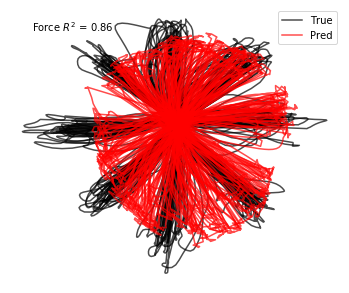

In [22]:
# show decoder now generalizes
dayk_behavior = np.concatenate(dayk_trials['force'], axis=-1).T
keep_trials = np.isnan(dayk_behavior).sum(axis=(1,2)) == 0
valid_dayk_behavior = dayk_behavior[keep_trials, :, :]
valid_align_gen_states = align_gen_states.T[keep_trials, :, :]
ntime, ndims, ntrials = valid_align_gen_states.shape

decode_gen_states = np.reshape(np.swapaxes(valid_align_gen_states, 0, 1), (model.cfg.MODEL.GEN_DIM, ntrials * ntime)).T
lagged_decode_gen_states = generate_lagged_matrix(decode_gen_states, 3)
decode_behavior = np.reshape(np.swapaxes(valid_dayk_behavior, 0, 1), (2, ntrials * ntime)).T

score = decoder.score(lagged_decode_gen_states, decode_behavior[3:, :])
dayk_pred_force = decoder.predict(lagged_decode_gen_states)
print(score)
# plot decoder outputs
plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_aspect('equal')
true_behavior = np.split(decode_behavior, ntrials, axis=0)
true_plots = [plt.plot(tr[:, 0], tr[:, 1], label='True', color='k', alpha=0.7) for tr in true_behavior]
predicted_behavior = np.split(np.pad(dayk_pred_force, ((3,0), (0,0)), constant_values=np.nan), ntrials, axis=0)
pred_plots = [plt.plot(tr[:, 0], tr[:, 1], label='Pred', color='r', alpha=0.7) for tr in predicted_behavior]
# make axes invisible
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.legend([true_plots[0][0], pred_plots[0][0]], ['True', 'Pred'])
plt.text(-950, 600, 'Force $R^2$ = {:.2f}'.format(score))
plt.show()